In [975]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.preprocessing import StandardScaler

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read in data


In [423]:
dict_of_stocks_and_dfs = {}
for file_ in glob.glob('../data/updated_historical_stock_data/*.csv'):
    stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
    print(f"Reading in {stock_name}")
    dict_of_stocks_and_dfs[stock_name] = pd.read_csv(f"{file_}")


Reading in pnr
Reading in bac
Reading in ni
Reading in vno
Reading in ual
Reading in efx
Reading in ph
Reading in rop
Reading in are
Reading in pg
Reading in pvh
Reading in lb
Reading in cern
Reading in peg
Reading in adbe
Reading in emr
Reading in ce
Reading in eqix
Reading in rost
Reading in so


In [424]:
# key is company value is df of data
dict_of_stocks_and_dfs.keys()

dict_keys(['pnr', 'bac', 'ni', 'vno', 'ual', 'efx', 'ph', 'rop', 'are', 'pg', 'pvh', 'lb', 'cern', 'peg', 'adbe', 'emr', 'ce', 'eqix', 'rost', 'so'])

# Create correlation & variance features
- Daily, weekly, 30-days, 90-days, 180-days, 365-days

In [425]:

# here the date is not the index, yet
first_stock_df = dict_of_stocks_and_dfs['ph'].loc[ dict_of_stocks_and_dfs['ph'].date.isin(dict_of_stocks_and_dfs['emr'].date), :]

In [426]:
np.var(first_stock_df.close)

2629.342599254268

In [427]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-02']

,date,open,high,low,close,volume


In [428]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-03']

,date,open,high,low,close,volume
0,2017-01-03,142.2,144.25,140.83,142.55,1115090


In [429]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-04']

,date,open,high,low,close,volume
1,2017-01-04,142.5,143.2,141.9,142.64,637928


In [430]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-05']

,date,open,high,low,close,volume
2,2017-01-05,142.35,142.67,139.92,141.37,557915


In [431]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-06']

,date,open,high,low,close,volume
3,2017-01-06,141.91,142.4,141.06,141.49,727481


In [432]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2018-01-08']

,date,open,high,low,close,volume
255,2018-01-08,203.81,206.41,203.67,205.55,974719


In [433]:
2017-01-04

SyntaxError: invalid token (<ipython-input-433-4d9b7842368f>, line 1)

In [434]:

# here the date is not the index, yet
first_stock_df = dict_of_stocks_and_dfs['ph'].loc[ dict_of_stocks_and_dfs['ph'].date.isin(dict_of_stocks_and_dfs['emr'].date), :]
#  filter second df by the dates in first

# here the date is not the index, yet
second_stock_df = dict_of_stocks_and_dfs['emr'].loc[ dict_of_stocks_and_dfs['emr'].date.isin(dict_of_stocks_and_dfs['ph'].date), :]

## Set the date as the index and sort

In [435]:
first_stock_df = first_stock_df.sort_values('date')
second_stock_df = second_stock_df.sort_values('date')

first_stock_df = first_stock_df.set_index('date')
second_stock_df = second_stock_df.set_index('date')

In [762]:
#pd.DataFrame(
first_stock_df.volume.rolling(7).std()[:10] # .fillna(method='backfill').astype(int))

date
1985-07-01              NaN
1985-07-02              NaN
1985-07-03              NaN
1985-07-05              NaN
1985-07-08              NaN
1985-07-09              NaN
1985-07-10     95419.697574
1985-07-11     93678.013509
1985-07-12    217940.467100
1985-07-15    232513.207094
Name: volume, dtype: float64

In [541]:
corr_df = pd.DataFrame(first_stock_df.close.rolling(7).corr(second_stock_df.close)).fillna(method='backfill').rename({'close': 'rolling_corr'},axis=1)

In [551]:
corr_df

,rolling_corr
date,
1985-07-01,0.770455
1985-07-02,0.770455
1985-07-03,0.770455
1985-07-05,0.770455
1985-07-08,0.770455
...,...
2020-04-13,0.971589
2020-04-14,0.951834
2020-04-15,0.819152


In [436]:
first_stock_df.index.max()

'2020-04-17'

In [437]:
second_stock_df.index.max()

'2020-04-17'

In [438]:
np.corrcoef(first_stock_df.close, second_stock_df.close) # all time corrcoef

array([[1.        , 0.95325325],
       [0.95325325, 1.        ]])

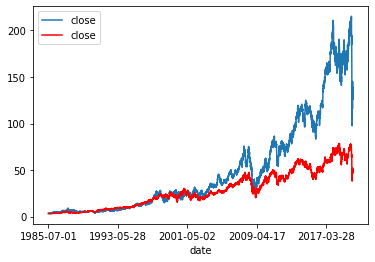

In [439]:

ax = first_stock_df.plot(y='close')
second_stock_df.plot(y='close', color='red', ax=ax)

In [440]:
n_rows = len(first_stock_df)
n_days_stride = 365

previous_row = 0
c = 0

correlation_per_time_period = defaultdict(list)
for day_window in range(n_rows):
    
    if day_window % 100 == 0:
        print(f"Idx {day_window} out of {n_rows}")
    first_stock= first_stock_df.iloc[previous_row:day_window + n_days_stride, :]
    second_stock = second_stock_df.iloc[previous_row:day_window + n_days_stride, :]
#     print(f"Correcoef for {first_stock.index.min()} to {second_stock.index.max()}")
    correlation = np.corrcoef(first_stock.close, second_stock.close)[0,1]

#     print(correlation) 
    
    correlation_per_time_period['date'].append(first_stock.index.min())
    correlation_per_time_period['correlation'].append(correlation)
    
    previous_row+= 1

    
    

Idx 0 out of 8770
Idx 100 out of 8770
Idx 200 out of 8770
Idx 300 out of 8770
Idx 400 out of 8770
Idx 500 out of 8770
Idx 600 out of 8770
Idx 700 out of 8770
Idx 800 out of 8770
Idx 900 out of 8770
Idx 1000 out of 8770
Idx 1100 out of 8770
Idx 1200 out of 8770
Idx 1300 out of 8770
Idx 1400 out of 8770
Idx 1500 out of 8770
Idx 1600 out of 8770
Idx 1700 out of 8770
Idx 1800 out of 8770
Idx 1900 out of 8770
Idx 2000 out of 8770
Idx 2100 out of 8770
Idx 2200 out of 8770
Idx 2300 out of 8770
Idx 2400 out of 8770
Idx 2500 out of 8770
Idx 2600 out of 8770
Idx 2700 out of 8770
Idx 2800 out of 8770
Idx 2900 out of 8770
Idx 3000 out of 8770
Idx 3100 out of 8770
Idx 3200 out of 8770
Idx 3300 out of 8770
Idx 3400 out of 8770
Idx 3500 out of 8770
Idx 3600 out of 8770
Idx 3700 out of 8770
Idx 3800 out of 8770
Idx 3900 out of 8770
Idx 4000 out of 8770
Idx 4100 out of 8770
Idx 4200 out of 8770
Idx 4300 out of 8770
Idx 4400 out of 8770
Idx 4500 out of 8770
Idx 4600 out of 8770
Idx 4700 out of 8770
Idx 

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [443]:
correlation_df = pd.DataFrame(correlation_per_time_period)
correlation_df.set_index('date')

,correlation
date,
1985-07-01,0.908957
1985-07-02,0.908344
1985-07-03,0.908069
1985-07-05,0.907743
1985-07-08,0.907586
...,...
2020-04-13,0.936544
2020-04-14,0.965812
2020-04-15,0.970104


In [444]:
correlation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8770 entries, 0 to 8769
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         8770 non-null   object 
 1   correlation  8769 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.2+ KB


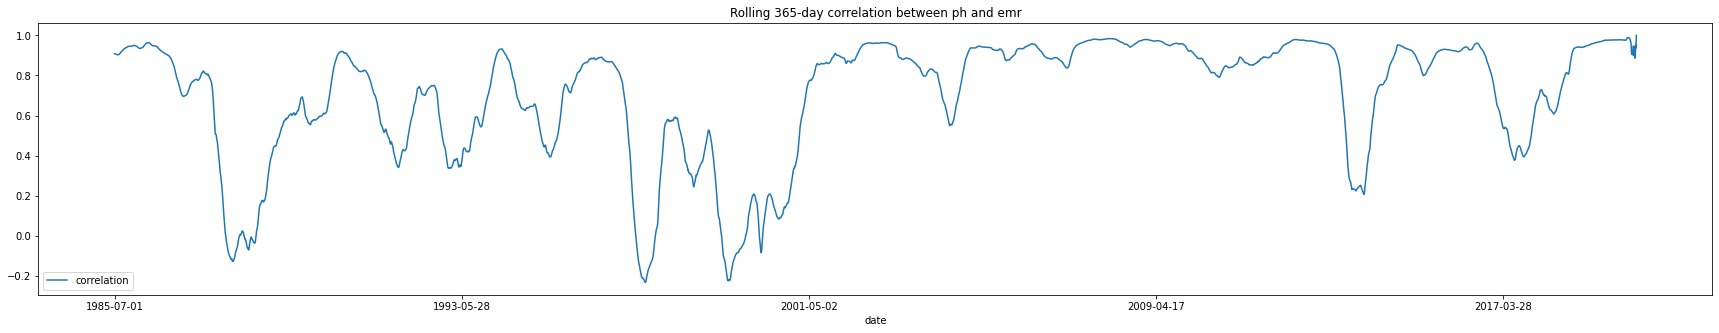

In [445]:
correlation_df.set_index('date').plot(figsize=(30,5), title='Rolling 365-day correlation between ph and emr')

In [446]:
correlation_df.date.max()

'2020-04-17'

In [447]:
correlation_df.rolling(7).sum()

,correlation
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
8765,6.469109
8766,6.508580
8767,6.539512
8768,6.653166


In [448]:
correlation_df

,date,correlation
0,1985-07-01,0.908957
1,1985-07-02,0.908344
2,1985-07-03,0.908069
3,1985-07-05,0.907743
4,1985-07-08,0.907586
...,...,...
8765,2020-04-13,0.936544
8766,2020-04-14,0.965812
8767,2020-04-15,0.970104
8768,2020-04-16,1.000000


## Build a function to create correlation features for all pairs of stocks

In [1108]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 3, 6, 7, 8, 10], verbose=False):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            stock_pair = f"{first_stock_name}_{second_stock_name}"
            
            if (first_stock_name == second_stock_name) or ( stock_pair in pairs_of_stocks) :
                continue
            else:
                pairs_of_stocks.append(stock_pair)
            if verbose:
                print('-------')
                print(f"{first_stock_name} & {second_stock_name}")
                print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]

            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{first_stock_name}"].date), :]

            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, final_feature_df, 
                    first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                   
                current_feature_cols = set(features_df.columns)
                final_feature_cols = set(final_feature_df.columns)
                
                # as we go through different pairs will have multiple var / corr for the first stock
                # pnc_bar calcualtes corr for pnr
                #pnr_bat calculates corr for pnr
                # don't want the same cols
#                 if len(current_feature_cols.intersection(final_feature_cols)) > 0:
#                     for overlapping_col in current_feature_cols.intersection(final_feature_cols):
#                         features_df = features_df.drop(f"{overlapping_col}", axis=1)
                
                if (f"{first_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    all_features_df = features_df
                else:
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')
            if verbose:
                end = time.time()
                print(f"Building all features took {(end-start)/60} minutes")
                start = time.time()

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes for {len(pairs_of_stocks)} pairs")
    final_feature_df = add_time_feature(final_feature_df)
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range

In [1109]:
set([1,2,3]).intersection(set([2,3,4]))

{2, 3}

In [1110]:
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=55):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = datetime.datetime(1970,1,1)

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')
    

In [1111]:
def add_time_feature(final_stock_df):
    
    days = [i.day for i in final_stock_df.index]
    months = [i.month for i in final_stock_df.index]
    quarters = [i.quarter for i in final_stock_df.index]
    years = [i.year for i in final_stock_df.index]

    final_stock_df['day'] = days
    final_stock_df['month'] = months
    final_stock_df['quarter'] = quarters
    final_stock_df['year'] = years
    
    return final_stock_df

In [1112]:
def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, final_stock_df, 
                                             first_stock_name=None, second_stock_name=None, verbose=False):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    if verbose:
        print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    # add cols
    
    current_feature_cols = list(final_stock_df.columns)
    

    # as we go through different pairs will have multiple var / corr for the first stock
    # pnc_bar calcualtes corr for pnr
    #pnr_bat calculates corr for pnr
    # don't want the same cols
    if f"{first_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        
        rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
        
    if f"{second_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round( 6)
        rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock
        
    if f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
        
    if f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [1113]:
# 100 minutes for 20 stocks (20*20 = 400 pairs each pair takes .25 minutes)
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs)

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':



Finished 0.0 pct of stocks


Finished 0.05 pct of stocks


Finished 0.1 pct of stocks


Finished 0.15 pct of stocks


Finished 0.2 pct of stocks


Finished 0.25 pct of stocks


Finished 0.3 pct of stocks


Finished 0.35 pct of stocks


Finished 0.4 pct of stocks


Finished 0.45 pct of stocks


Finished 0.5 pct of stocks


Finished 0.55 pct of stocks


Finished 0.6 pct of stocks


Finished 0.65 pct of stocks


Finished 0.7 pct of stocks


Finished 0.75 pct of stocks


Finished 0.8 pct of stocks


Finished 0.85 pct of stocks


Finished 0.9 pct of stocks


Finished 0.95 pct of stocks

Total time 1.6907136162122092 minutes for 380 pairs


In [1114]:
final_stock_df[~pd.isna(final_stock_df.pnr_bac_close_corr_rolling_3_days)]

,pnr_bac_close_corr_rolling_3_days,pnr_close_std_rolling_3_days,bac_close_std_rolling_3_days,pnr_volume_std_rolling_3_days,bac_volume_std_rolling_3_days,pnr_volume,bac_volume,pnr_bac_close_corr_rolling_6_days,pnr_close_std_rolling_6_days,bac_close_std_rolling_6_days,...,so_eqix_close_corr_rolling_10_days,so_rost_close_corr_rolling_3_days,so_rost_close_corr_rolling_6_days,so_rost_close_corr_rolling_7_days,so_rost_close_corr_rolling_8_days,so_rost_close_corr_rolling_10_days,day,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,,
2005-02-25,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,425379.0,8656470.0,-0.299410,0.324757,0.235476,...,0.622068,0.756800,0.695732,0.653203,0.612758,0.638917,25,2,1,2005
2005-02-28,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,489224.0,10653157.0,-0.299410,0.324757,0.235476,...,0.622068,0.747056,0.616683,0.582613,0.516252,0.461771,28,2,1,2005
2005-03-01,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,479025.0,11230182.0,-0.299410,0.324757,0.235476,...,0.622068,0.212150,0.873937,0.675900,0.566409,0.376416,1,3,1,2005
2005-03-02,-0.985118,0.160553,0.258003,15394.968236,4.720071e+05,458965.0,10294635.0,-0.299410,0.324757,0.235476,...,0.622068,0.742616,0.766851,0.848152,0.667500,0.359682,2,3,1,2005
2005-03-03,-0.998760,0.217682,0.359674,70107.715840,7.917529e+05,589176.0,9655981.0,-0.299410,0.324757,0.235476,...,0.622068,-0.955941,0.062286,0.353190,0.527597,0.222706,3,3,1,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-13,0.285322,0.757166,0.717937,302410.058942,2.497579e+07,806105.0,83164717.0,0.899761,1.619308,1.780286,...,0.892463,0.521586,0.921538,0.934788,0.897778,0.835256,13,4,2,2020
2020-04-14,0.744225,0.690869,0.605062,328987.136047,2.289724e+07,1355716.0,88991066.0,0.812464,0.809988,1.265155,...,0.917852,0.427205,0.761710,0.927941,0.941267,0.881149,14,4,2,2020
2020-04-15,0.669138,0.557704,0.948736,743926.304548,8.053413e+06,2278293.0,99082222.0,0.763178,0.742662,1.054806,...,0.893572,0.518279,0.668194,0.674462,0.897253,0.895042,15,4,2,2020


In [1001]:
# drop na
final_stock_df = final_stock_df.dropna()

In [1002]:
len(pairs_of_stocks)

380

In [1003]:
# last date of dtaa
last_date_of_data = '2020-04-17'

In [1004]:
final_stock_df[final_stock_df.index == last_date_of_data]

,pnr_bac_close_corr_rolling_3_days,pnr_close_std_rolling_3_days,bac_close_std_rolling_3_days,pnr_volume_std_rolling_3_days,bac_volume_std_rolling_3_days,pnr_volume,bac_volume,pnr_bac_close_corr_rolling_6_days,pnr_close_std_rolling_6_days,bac_close_std_rolling_6_days,...,so_rost_close_corr_rolling_3_days,so_rost_close_corr_rolling_6_days,so_rost_close_corr_rolling_7_days,so_rost_close_corr_rolling_8_days,so_rost_close_corr_rolling_10_days,so_rost_close_corr_rolling_15_days,day,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,,
2020-04-17,0.989084,0.590706,0.934577,589549.347253,4.995399e+06,1153740.0,92800270.0,0.925646,0.826182,1.244438,...,0.999178,0.34824,0.34614,0.556408,0.862189,0.80474,17,4,2,2020


In [792]:
pairs_of_stocks

['pnr_bac']

In [793]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,pnr_bac_close_corr_rolling_3_days,pnr_close_std_rolling_3_days,bac_close_std_rolling_3_days,pnr_volume_std_rolling_3_days,bac_volume_std_rolling_3_days,pnr_volume,bac_volume,pnr_bac_close_corr_rolling_6_days,pnr_close_std_rolling_6_days,bac_close_std_rolling_6_days,...,pnr_bac_close_corr_rolling_30_days,pnr_close_std_rolling_30_days,bac_close_std_rolling_30_days,pnr_volume_std_rolling_30_days,bac_volume_std_rolling_30_days,pnr_bac_close_corr_rolling_60_days,pnr_close_std_rolling_60_days,bac_close_std_rolling_60_days,pnr_volume_std_rolling_60_days,bac_volume_std_rolling_60_days
date,,,,,,,,,,,,,,,,,,,,,
2005-02-25,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,425379.0,8656470.0,-0.299410,0.324757,0.235476,...,0.941902,1.048560,1.025981,196053.072443,3.173304e+06,0.783557,1.577593,0.847369,415542.833243,2.889315e+06
2005-02-28,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,489224.0,10653157.0,-0.299410,0.324757,0.235476,...,0.941902,1.048560,1.025981,196053.072443,3.173304e+06,0.783557,1.577593,0.847369,415542.833243,2.889315e+06
2005-03-01,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,479025.0,11230182.0,-0.299410,0.324757,0.235476,...,0.941902,1.048560,1.025981,196053.072443,3.173304e+06,0.783557,1.577593,0.847369,415542.833243,2.889315e+06
2005-03-02,-0.985118,0.160553,0.258003,15394.968236,4.720071e+05,458965.0,10294635.0,-0.299410,0.324757,0.235476,...,0.941902,1.048560,1.025981,196053.072443,3.173304e+06,0.783557,1.577593,0.847369,415542.833243,2.889315e+06
2005-03-03,-0.998760,0.217682,0.359674,70107.715840,7.917529e+05,589176.0,9655981.0,-0.299410,0.324757,0.235476,...,0.941902,1.048560,1.025981,196053.072443,3.173304e+06,0.783557,1.577593,0.847369,415542.833243,2.889315e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-13,0.285322,0.757166,0.717937,302410.058942,2.497579e+07,806105.0,83164717.0,0.899761,1.619308,1.780286,...,0.873234,5.061855,2.732167,394350.015547,2.822167e+07,0.956415,7.296587,5.942469,501447.278455,4.353774e+07
2020-04-14,0.744225,0.690869,0.605062,328987.136047,2.289724e+07,1355716.0,88991066.0,0.812464,0.809988,1.265155,...,0.855684,4.749327,2.429670,398047.422672,2.810251e+07,0.955830,7.242258,5.903685,499324.009940,4.329414e+07
2020-04-15,0.669138,0.557704,0.948736,743926.304548,8.053413e+06,2278293.0,99082222.0,0.763178,0.742662,1.054806,...,0.838961,4.503525,2.213206,413290.376634,2.791707e+07,0.955499,7.181165,5.880124,508435.387384,4.311943e+07


In [794]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,pnr_bac_close_corr_rolling_3_days,pnr_close_std_rolling_3_days,bac_close_std_rolling_3_days,pnr_volume_std_rolling_3_days,bac_volume_std_rolling_3_days,pnr_volume,bac_volume,pnr_bac_close_corr_rolling_6_days,pnr_close_std_rolling_6_days,bac_close_std_rolling_6_days,...,pnr_bac_close_corr_rolling_30_days,pnr_close_std_rolling_30_days,bac_close_std_rolling_30_days,pnr_volume_std_rolling_30_days,bac_volume_std_rolling_30_days,pnr_bac_close_corr_rolling_60_days,pnr_close_std_rolling_60_days,bac_close_std_rolling_60_days,pnr_volume_std_rolling_60_days,bac_volume_std_rolling_60_days
date,,,,,,,,,,,,,,,,,,,,,
2005-02-25,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,425379.0,8656470.0,-0.299410,0.324757,0.235476,...,0.941902,1.048560,1.025981,196053.072443,3.173304e+06,0.783557,1.577593,0.847369,415542.833243,2.889315e+06
2005-02-28,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,489224.0,10653157.0,-0.299410,0.324757,0.235476,...,0.941902,1.048560,1.025981,196053.072443,3.173304e+06,0.783557,1.577593,0.847369,415542.833243,2.889315e+06
2005-03-01,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,479025.0,11230182.0,-0.299410,0.324757,0.235476,...,0.941902,1.048560,1.025981,196053.072443,3.173304e+06,0.783557,1.577593,0.847369,415542.833243,2.889315e+06
2005-03-02,-0.985118,0.160553,0.258003,15394.968236,4.720071e+05,458965.0,10294635.0,-0.299410,0.324757,0.235476,...,0.941902,1.048560,1.025981,196053.072443,3.173304e+06,0.783557,1.577593,0.847369,415542.833243,2.889315e+06
2005-03-03,-0.998760,0.217682,0.359674,70107.715840,7.917529e+05,589176.0,9655981.0,-0.299410,0.324757,0.235476,...,0.941902,1.048560,1.025981,196053.072443,3.173304e+06,0.783557,1.577593,0.847369,415542.833243,2.889315e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-13,0.285322,0.757166,0.717937,302410.058942,2.497579e+07,806105.0,83164717.0,0.899761,1.619308,1.780286,...,0.873234,5.061855,2.732167,394350.015547,2.822167e+07,0.956415,7.296587,5.942469,501447.278455,4.353774e+07
2020-04-14,0.744225,0.690869,0.605062,328987.136047,2.289724e+07,1355716.0,88991066.0,0.812464,0.809988,1.265155,...,0.855684,4.749327,2.429670,398047.422672,2.810251e+07,0.955830,7.242258,5.903685,499324.009940,4.329414e+07
2020-04-15,0.669138,0.557704,0.948736,743926.304548,8.053413e+06,2278293.0,99082222.0,0.763178,0.742662,1.054806,...,0.838961,4.503525,2.213206,413290.376634,2.791707e+07,0.955499,7.181165,5.880124,508435.387384,4.311943e+07


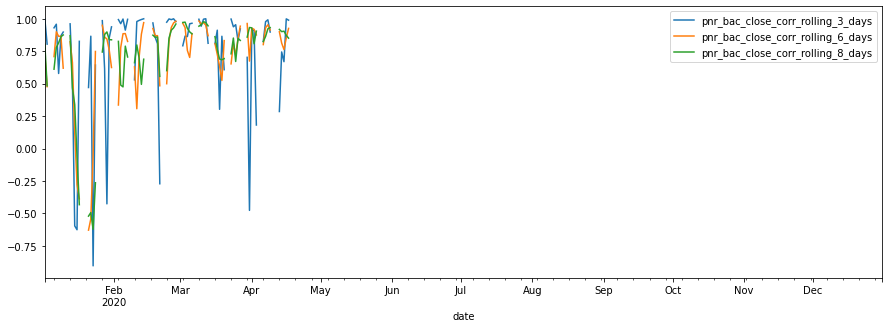

In [930]:
final_stock_df.loc[((final_stock_df.index>'2020-01-01') & (final_stock_df.index<'2021-01-01')), :][['pnr_bac_close_corr_rolling_3_days','pnr_bac_close_corr_rolling_6_days', 
                                                'pnr_bac_close_corr_rolling_8_days']].plot(figsize=(15,5))

In [931]:
final_stock_df.columns

Index(['pnr_bac_close_corr_rolling_3_days', 'pnr_close_std_rolling_3_days',
       'bac_close_std_rolling_3_days', 'pnr_volume_std_rolling_3_days',
       'bac_volume_std_rolling_3_days', 'pnr_volume', 'bac_volume',
       'pnr_bac_close_corr_rolling_6_days', 'pnr_close_std_rolling_6_days',
       'bac_close_std_rolling_6_days',
       ...
       'so_eqix_close_corr_rolling_7_days',
       'so_eqix_close_corr_rolling_8_days',
       'so_eqix_close_corr_rolling_10_days',
       'so_eqix_close_corr_rolling_15_days',
       'so_rost_close_corr_rolling_3_days',
       'so_rost_close_corr_rolling_6_days',
       'so_rost_close_corr_rolling_7_days',
       'so_rost_close_corr_rolling_8_days',
       'so_rost_close_corr_rolling_10_days',
       'so_rost_close_corr_rolling_15_days'],
      dtype='object', length=2540)

## Train Test Split to predict correlation over the next 7 days
- rolling evey day make a predictions about what the correlation will be for the next 7 days stock price

In [932]:
datetime.timedelta(7)

datetime.timedelta(days=7)

- Rolling Predictions

In [800]:
# drop na
final_stock_df = final_stock_df.dropna()

In [801]:
final_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3811 entries, 2005-02-25 to 2020-04-17
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   pnr_bac_close_corr_rolling_3_days   3811 non-null   float64
 1   pnr_close_std_rolling_3_days        3811 non-null   float64
 2   bac_close_std_rolling_3_days        3811 non-null   float64
 3   pnr_volume_std_rolling_3_days       3811 non-null   float64
 4   bac_volume_std_rolling_3_days       3811 non-null   float64
 5   pnr_volume                          3811 non-null   float64
 6   bac_volume                          3811 non-null   float64
 7   pnr_bac_close_corr_rolling_6_days   3811 non-null   float64
 8   pnr_close_std_rolling_6_days        3811 non-null   float64
 9   bac_close_std_rolling_6_days        3811 non-null   float64
 10  pnr_volume_std_rolling_6_days       3811 non-null   float64
 11  bac_volume_std_rolling_6_

In [807]:
def evaluate_predictios_on_rolling_historical_data(final_stock_df, rolling_window = 7, starting_date_index= 3500,
                                                   y_col='pnr_bac_close_corr_rolling_7_days'):
    """
    Backtesting
    
    For now, assumes the final_stock only has pairs the one start stock and all others, pnc_bac, pnc_bar ...etc
    """
    
    predicted_corr_7_days = []
    actual = []
    rmse_corr_7_days = []
    prediction_date = []

    print_idx = 100
     # otherwise, takes too long
    start = time.time()

    final_row = None
    for date_idx, date in enumerate(list(final_stock_df.index)[starting_date_index:]):
    #     print((date_id x+ starting_date_index+rolling_window+1))
    #     print(len(final_stock_df))

        if final_row:
            break
        if (date_idx + starting_date_index +rolling_window +1) == len(final_stock_df): # last row
            final_row = True
            # need to use the dates from the DF due to weekends
            train_dates = final_stock_df.index[:starting_date_index+date_idx]
            # The test is the rolling 7-day corr looking back the past seven days
            # Therefore, the test_date should be seven dates ahead of the data we are training on

            test_date = final_stock_df.index[starting_date_index+rolling_window+date_idx]

        else:
            # need to use the dates from the DF due to weekends
            train_dates = final_stock_df.index[:starting_date_index+date_idx+1]
            # The test is the rolling 7-day corr looking back the past seven days
            # Therefore, the test_date should be seven dates ahead of the data we are training on

            test_date = final_stock_df.index[starting_date_index+rolling_window+date_idx+1]


        prediction_date.append(test_date)

        if date_idx % print_idx == 0:
            print(f"Train dates =  {train_dates}")
            print(F"Prediction date = {test_date}")

        train_df = final_stock_df[final_stock_df.index.isin(list(train_dates))]
        test_df = final_stock_df[final_stock_df.index == test_date]

        # TODO - search for the rolling 7-days column, don't hardcode
        X_train, y_train = train_df.loc[:, train_df.columns != f"{y_col}"],  train_df.pnr_bac_close_corr_rolling_7_days
        X_test, y_test = test_df.loc[:, test_df.columns != f"{y_col}"],  test_df.pnr_bac_close_corr_rolling_7_days

    #     gb = GradientBoostingRegressor()
        rf = RandomForestRegressor(n_jobs=-1)

        X_train = np.nan_to_num(X_train.astype(np.float32)) # converting to float 32 throws some infinity errors
        rf.fit(X_train, y_train)

        prediction = rf.predict(X_test)

        predicted_corr_7_days.append(prediction[0])
        actual.append(y_test.values[0])

        rmse_corr_7_days.append(np.sqrt(mean_squared_error(y_test, prediction)))
        if date_idx % print_idx == 0:
            print('prediction = ', prediction)
            print('actual =', y_test.values)
            print('')


    end = time.time()

    print(f"Predictions took {(end-start)/60} minutes")
    
    prediction_df = pd.DataFrame( {'actual_corr_7_days':actual, 'predicted_corr_7_days': predicted_corr_7_days, 'prediction_date':prediction_date})
    
    return prediction_df

In [810]:
evaluate_predictios_on_rolling_historical_data(final_stock_df)

Train dates =  DatetimeIndex(['2005-02-25', '2005-02-28', '2005-03-01', '2005-03-02',
               '2005-03-03', '2005-03-04', '2005-03-07', '2005-03-08',
               '2005-03-09', '2005-03-10',
               ...
               '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15',
               '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-22',
               '2019-01-23', '2019-01-24'],
              dtype='datetime64[ns]', name='date', length=3501, freq=None)
Prediction date = 2019-02-05 00:00:00
prediction =  [-0.39793788]
actual = [-0.606127]



KeyboardInterrupt: 

In [803]:
np.mean(rmse_corr_7_days) # rolling 6 + 8 day corr added

0.07047565705321027

In [786]:
np.mean(rmse_corr_7_days) # rolling 6 day corr added

0.1364248274131171

In [756]:
np.mean(rmse_corr_7_days)

0.21447151296988917

In [707]:
np.mean(rmse_corr_7_days)

0.27645221273913956

In [689]:
np.mean(rmse_corr_7_days)

0.299352551057616

In [757]:
prediction_df = pd.DataFrame( {'actual_corr_7_days':actual, 'predicted_corr_7_days': predicted_corr_7_days, 'prediction_date':prediction_date})

In [758]:
prediction_df = prediction_df.set_index('prediction_date')

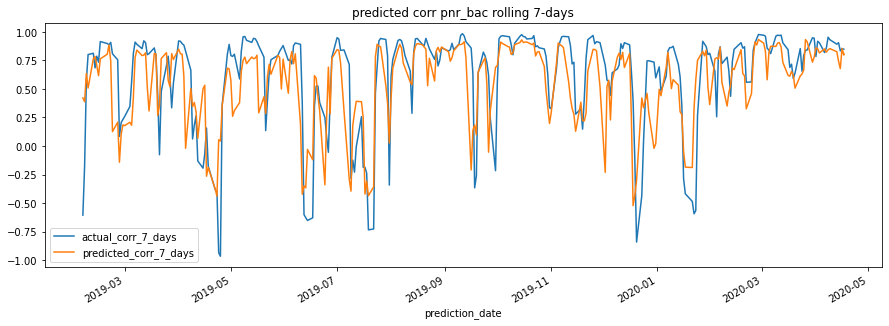

In [787]:
prediction_df.plot(title='predicted corr pnr_bac rolling 7-days', figsize=(15,5))

In [510]:
prediction_df.index

DatetimeIndex(['2019-11-20', '2019-11-21', '2019-11-22', '2019-11-25',
               '2019-11-26', '2019-11-27', '2019-11-29', '2019-12-02',
               '2019-12-03', '2019-12-04',
               ...
               '2020-04-03', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-16'],
              dtype='datetime64[ns]', name='prediction_date', length=102, freq=None)

## Feature Importances
- nit: only based on last tree fit

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 <a list of 35 Text major ticklabel objects>)

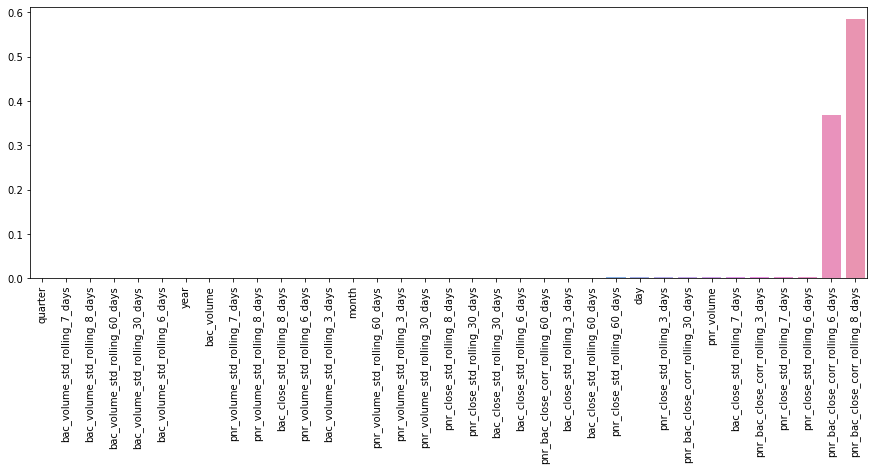

In [804]:
cols = list(final_stock_df.columns)
cols.remove('pnr_bac_close_corr_rolling_7_days')

plt.figure(figsize=(15,5))
sns.barplot(x=np.array(cols)[np.argsort(rf.feature_importances_)], y=rf.feature_importances_[np.argsort(rf.feature_importances_)])
plt.xticks(rotation=90)

# given all feature, predict next 7-days for each stock pair

In [946]:
final_stock_df

,pnr_bac_close_corr_rolling_3_days,pnr_close_std_rolling_3_days,bac_close_std_rolling_3_days,pnr_volume_std_rolling_3_days,bac_volume_std_rolling_3_days,pnr_volume,bac_volume,pnr_bac_close_corr_rolling_6_days,pnr_close_std_rolling_6_days,bac_close_std_rolling_6_days,...,so_rost_close_corr_rolling_3_days,so_rost_close_corr_rolling_6_days,so_rost_close_corr_rolling_7_days,so_rost_close_corr_rolling_8_days,so_rost_close_corr_rolling_10_days,so_rost_close_corr_rolling_15_days,day,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,,
2006-01-25,0.160943,0.085035,0.316898,38247.048047,5.665887e+06,536451.0,16050693.0,-0.200975,0.135596,0.503417,...,0.941534,0.388549,0.085605,-0.271269,-0.535700,-0.490134,25,1,1,2006
2006-01-26,0.151438,0.085035,0.312676,38258.452299,2.674882e+06,495644.0,19569182.0,0.495316,0.127010,0.429717,...,0.795121,0.644368,0.427572,0.146116,-0.398869,-0.480760,26,1,1,2006
2006-01-27,0.263368,0.682751,0.128873,95321.163769,3.290067e+06,677322.0,12994462.0,0.561520,0.524121,0.354740,...,0.090228,0.198678,0.615420,0.420237,-0.214416,-0.570385,27,1,1,2006
2006-01-30,-0.675648,0.625617,0.206737,90878.492804,3.303817e+06,581843.0,15711371.0,0.370031,0.617659,0.333465,...,0.996725,0.413728,0.277061,0.648599,0.219410,-0.532873,30,1,1,2006
2006-01-31,-0.245173,0.012767,0.268676,188503.415569,2.754969e+06,945436.0,18504226.0,-0.160903,0.636590,0.264541,...,0.969496,0.787401,0.659167,0.568100,0.609912,-0.312471,31,1,1,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-13,0.285322,0.757166,0.717937,302410.058942,2.497579e+07,806105.0,83164717.0,0.899761,1.619308,1.780286,...,0.521586,0.921538,0.934788,0.897778,0.835256,0.907727,13,4,2,2020
2020-04-14,0.744225,0.690869,0.605062,328987.136047,2.289724e+07,1355716.0,88991066.0,0.812464,0.809988,1.265155,...,0.427205,0.761710,0.927941,0.941267,0.881149,0.854858,14,4,2,2020
2020-04-15,0.669138,0.557704,0.948736,743926.304548,8.053413e+06,2278293.0,99082222.0,0.763178,0.742662,1.054806,...,0.518279,0.668194,0.674462,0.897253,0.895042,0.818167,15,4,2,2020


In [1013]:
np.nan_to_num(final_stock_df.astype(np.float32))

array([[1.609430e-01, 8.503500e-02, 3.168980e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       [1.514380e-01, 8.503500e-02, 3.126760e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       [2.633680e-01, 6.827510e-01, 1.288730e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       ...,
       [6.691380e-01, 5.577040e-01, 9.487360e-01, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03],
       [9.991570e-01, 8.747000e-01, 1.176194e+00, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03],
       [9.890840e-01, 5.907060e-01, 9.345770e-01, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03]], dtype=float32)

- build predicted 7 day corr for each pair

In [1005]:
# remove all 7_days_corr columns ex: so_rost_close_corr_rolling_7_days
### format: f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"
# using all data up until the last day, predict 7-day corr for each stock pair

In [1116]:
test_date = final_stock_df.index.max()
train_dates = final_stock_df.index[final_stock_df.index < test_date - datetime.timedelta(7)] # seven days before

train_df = final_stock_df[final_stock_df.index.isin(train_dates)]
test_df = final_stock_df[final_stock_df.index == test_date]

final_stock_df = final_stock_df.dropna()

n_days_corr_predictions = 7


pct_change_corr = []
actual_corr = []
predicted_corr = []
last_corr_for_prediction_day = []
pred_dates = []
start = time.time()

for stock_pairing in pairs_of_stocks:
    pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"
    
    # remove the current 7-day corr for this stock
    train_X, train_y = train_df.loc[:, train_df.columns != f"{pred_col_name}"],  train_df[f"{pred_col_name}"]
    test_X, test_y = test_df.loc[:, test_df.columns != f"{pred_col_name}"],  test_df[f"{pred_col_name}"]

    
    train_X = np.nan_to_num(train_X.astype(np.float32)) 
    
    # standard scaler for cols
    scaler=StandardScaler()
    scaler.fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)
    
    
    # Make an instance of the Model
    # only train on train_x
    
    pca = PCA(n_components=5, whiten=True)
    pca.fit(train_X)
    
    train_X = pca.transform(train_X)
    test_X = pca.transform(test_X)
#     train_X = np.nan_to_num(train_X.astype(np.float32)) 
    
#     print(train_X.shape)

    
    # standaard scaler


    
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    rf.fit(train_X, train_y)
    

    prediction = np.array(rf.predict(test_X))[0]
    print(f"Stocks {stock_pairing}")
    print(f"Prediction = {prediction}")
    print(f"Actual = {test_y.values[0]}")
    
    pred_corr_pct_change, last_date = find_pct_change_pred_vs_last_corr(train_y, prediction)
    
    last_corr_date = train_y.index.max()
    last_corr = train_y[train_y.index.max()]    
    
    pct_change_corr.append(pred_corr_pct_change)
    pred_dates.append(last_date)
    actual_corr.append(test_y.values[0])
    predicted_corr.append(prediction)
    last_corr_for_prediction_day.append(last_corr)
    
    print(f"{stock_pairing} pct change 7-day corr of close from {last_date} to {test_date} is =  {pred_corr_pct_change}")


end = time.time()

print(f"Predictions took {(end-start)/60} mins")

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_bac
Prediction = 0.5111545700000001
Actual = 0.848838
pnr_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.451441414273664


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_ni
Prediction = 0.5240090900000004
Actual = 0.347275
pnr_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4146784808712646


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_vno
Prediction = 0.750667234
Actual = 0.411232
pnr_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.1465859857549695


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_ual
Prediction = 0.5962784233333333
Actual = 0.145586
pnr_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.11770553213568957


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_efx
Prediction = 0.4415641425000002
Actual = 0.267229
pnr_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.489009641444498


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_ph
Prediction = 0.8439641459999995
Actual = 0.934718
pnr_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.1372715093278819


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_rop
Prediction = 0.4341173433333333
Actual = 0.569769
pnr_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5229972471708051


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_are
Prediction = 0.6483437099999998
Actual = 0.215576
pnr_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2704903126789757


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_pg
Prediction = 0.04297287499999999
Actual = -0.588909
pnr_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9022575138631742


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_pvh
Prediction = 0.5025915899999999
Actual = 0.957368
pnr_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4783374712748667


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_lb
Prediction = 0.6228687960000002
Actual = 0.970683
pnr_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.36960938315986325


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_cern
Prediction = 0.2713706600000002
Actual = -0.146733
pnr_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7140179448376447


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_peg
Prediction = 0.4903196100000001
Actual = 0.026944
pnr_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.47591909831334567


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_adbe
Prediction = 0.6019022599999997
Actual = -0.586485
pnr_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.28055220011068427


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_emr
Prediction = 0.5775717740000001
Actual = 0.881648
pnr_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3935127325497755


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_ce
Prediction = 0.6544369599999998
Actual = 0.886964
pnr_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.30843498926887836


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_eqix
Prediction = 0.23562998000000018
Actual = 0.024828
pnr_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.723429576828319


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_rost
Prediction = 0.6565188399999994
Actual = 0.393781
pnr_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2394694858196703


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pnr_so
Prediction = 0.6532113350000006
Actual = 0.915914
pnr_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.311473449709025


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_pnr
Prediction = 0.54922351
Actual = 0.848838
bac_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4105867587308196


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_ni
Prediction = 0.30738392000000003
Actual = 0.477854
bac_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6815030856650239


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_vno
Prediction = 0.6534253549999997
Actual = 0.595423
bac_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3144324982478527


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_ual
Prediction = 0.5393028475
Actual = 0.251494
bac_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.36735923142705307


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_efx
Prediction = 0.16486943499999998
Actual = 0.213635
bac_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.8201187556325596


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_ph
Prediction = 0.7094291899999999
Actual = 0.960058
bac_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2719606686110354


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_rop
Prediction = 0.5487892299999999
Actual = 0.497688
bac_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.36218373838792506


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_are
Prediction = 0.4612979466666669
Actual = 0.249165
bac_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5299818057758932


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_pg
Prediction = -0.15843273999999993
Actual = -0.589151
bac_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.5158440805774696


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_pvh
Prediction = 0.8174844349999997
Actual = 0.945736
bac_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.12069515883720916


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_lb
Prediction = 0.3598500400000001
Actual = 0.922391
bac_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6174225648898461


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_cern
Prediction = 0.08445326
Actual = -0.208332
bac_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9143689708247232


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_peg
Prediction = 0.4282284433333334
Actual = 0.173964
bac_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5684786169929397


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_adbe
Prediction = 0.28501385
Actual = -0.581536
bac_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6405411421660063


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_emr
Prediction = 0.6461787700000002
Actual = 0.897132
bac_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3082479105981142


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_ce
Prediction = 0.3677878999999998
Actual = 0.965718
bac_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6264481956590189


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_eqix
Prediction = 0.12475513000000006
Actual = -0.028555
bac_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.860220064514611


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_rost
Prediction = 0.4282124508333334
Actual = 0.252392
bac_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4785172261706431


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks bac_so
Prediction = 0.4176765400000001
Actual = 0.953646
bac_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5734738964025603


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_pnr
Prediction = 0.5177666449999999
Actual = 0.347275
ni_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.42165133203015925


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_bac
Prediction = 0.39643590999999967
Actual = 0.477854
ni_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5892315575044454


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_vno
Prediction = 0.5841880099999998
Actual = 0.66298
ni_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3541772500342709


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_ual
Prediction = 0.3575305000000001
Actual = 0.359679
ni_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5855218617117471


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_efx
Prediction = 0.27438674999999985
Actual = 0.691253
ni_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7042927578402847


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_ph
Prediction = 0.4004901700000001
Actual = 0.47013
ni_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5847092841788499


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_rop
Prediction = 0.5667342700000002
Actual = 0.410618
ni_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3484082900172343


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_are
Prediction = 0.6493836900000004
Actual = 0.853054
ni_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3319867566700129


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_pg
Prediction = 0.3488071700000001
Actual = 0.203051
ni_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  0.025360603210065724


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_pvh
Prediction = 0.3264937533333334
Actual = 0.420521
ni_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6309408043345974


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_lb
Prediction = 0.4042896816666666
Actual = 0.40453
ni_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5412742511713331


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_cern
Prediction = 0.5999687700000003
Actual = 0.645322
ni_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3658686730216977


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_peg
Prediction = 0.6149810499999999
Actual = 0.809786
ni_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3577516542320771


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_adbe
Prediction = 0.52270203
Actual = 0.3467
ni_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4187491534809863


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_emr
Prediction = 0.39767436999999994
Actual = 0.247445
ni_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5678659657030591


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_ce
Prediction = 0.5310472814285715
Actual = 0.311814
ni_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4422235114643097


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_eqix
Prediction = 0.5200814799999999
Actual = 0.782412
ni_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.42377904058729887


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_rost
Prediction = 0.43291716250000006
Actual = 0.562377
ni_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5203426245491964


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ni_so
Prediction = 0.7424943775000002
Actual = 0.601316
ni_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2450972865998413


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_pnr
Prediction = 0.7987365166666669
Actual = 0.411232
vno_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.09193727108569538


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_bac
Prediction = 0.6683639957142857
Actual = 0.595423
vno_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2987590222865991


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_ni
Prediction = 0.5925760833333334
Actual = 0.66298
vno_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3449041932540612


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_ual
Prediction = 0.7191311500000002
Actual = 0.821329
vno_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.21488804096248726


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_efx
Prediction = 0.5234347199999998
Actual = 0.665408
vno_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4560032924479477


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_ph
Prediction = 0.7985865200000003
Actual = 0.558741
vno_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.1359308646463594


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_rop
Prediction = 0.3219344900000001
Actual = 0.388901
vno_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5446200622950725


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_are
Prediction = 0.7677914325000005
Actual = 0.639395
vno_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.20048626087264343


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_pg
Prediction = -0.08608551999999997
Actual = 0.012309
vno_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -2.6326338947049


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_pvh
Prediction = 0.8582028783333329
Actual = 0.538043
vno_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.06877512293132715


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_lb
Prediction = 0.58542296
Actual = 0.393704
vno_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3605925045681875


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_cern
Prediction = 0.06952625999999996
Actual = 0.307576
vno_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9245955073727501


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_peg
Prediction = 0.5732840066666665
Actual = 0.526397
vno_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.37656704655849926


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_adbe
Prediction = 0.5358345100000004
Actual = 0.048307
vno_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2277973466070229


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_emr
Prediction = 0.3560804180000001
Actual = 0.251679
vno_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5813773595109333


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_ce
Prediction = 0.7212534799999999
Actual = 0.481363
vno_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.25713509415928193


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_eqix
Prediction = 0.48998401
Actual = 0.400584
vno_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.35304026861588356


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_rost
Prediction = 0.59939489
Actual = 0.439933
vno_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2440053553230347


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks vno_so
Prediction = 0.5857152600000005
Actual = 0.625683
vno_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.34727828712097775


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_pnr
Prediction = 0.6329957499999996
Actual = 0.145586
ual_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.0633760562984319


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_bac
Prediction = 0.5431550799999999
Actual = 0.251494
ual_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3628402874963489


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_ni
Prediction = 0.42280291
Actual = 0.359679
ual_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5098528293399984


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_vno
Prediction = 0.7015166766666671
Actual = 0.821329
ual_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.23411865510866514


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_efx
Prediction = 0.3471747200000004
Actual = 0.415384
ual_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6116774585391875


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_ph
Prediction = 0.6388385599999998
Actual = 0.175928
ual_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.18145578808313612


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_rop
Prediction = 0.42189535999999994
Actual = 0.019921
ual_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.20718863630811568


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_are
Prediction = 0.5700950800000004
Actual = 0.633472
ual_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3835830342767982


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_pg
Prediction = -0.48403188000000014
Actual = 0.076191
ual_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  7.345521129674651


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_pvh
Prediction = 0.5467671499999994
Actual = 0.178844
ual_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.23946460265619252


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_lb
Prediction = 0.5442400957142854
Actual = 0.051689
ual_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2517185066899227


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_cern
Prediction = -0.06352623333333332
Actual = 0.353142
ual_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.0783615667979554


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_peg
Prediction = 0.0048063399999999975
Actual = 0.341162
ual_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.994075031958787


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_adbe
Prediction = 0.5558553199999999
Actual = 0.047701
ual_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.09194146398839487


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_emr
Prediction = 0.2630060339999999
Actual = -0.142493
ual_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6027153195802475


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_ce
Prediction = 0.4983852233333332
Actual = 0.113703
ual_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.41071873005963555


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_eqix
Prediction = 0.08520396999999993
Actual = 0.375885
ual_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.880013335924474


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_rost
Prediction = 0.6562109775000002
Actual = 0.189437
ual_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.04805352179488631


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ual_so
Prediction = 0.4803882899999997
Actual = 0.284456
ual_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.39067408005905724


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_pnr
Prediction = 0.500450575
Actual = 0.267229
efx_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.42086461706170564


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_bac
Prediction = 0.32865887000000027
Actual = 0.213635
efx_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6414158481952894


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_ni
Prediction = 0.27570290000000014
Actual = 0.691253
efx_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7028743399073174


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_vno
Prediction = 0.5975641024999999
Actual = 0.665408
efx_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.37896189937248115


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_ual
Prediction = 0.3432668800000001
Actual = 0.415384
efx_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6160484633186321


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_ph
Prediction = 0.41033673
Actual = 0.35326
efx_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.558128681482694


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_rop
Prediction = 0.44678134
Actual = 0.745908
efx_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.39171629486926385


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_are
Prediction = 0.6955215566666666
Actual = 0.657059
efx_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.25258625438933024


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_pg
Prediction = -0.3648677700000001
Actual = 0.559069
efx_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -9.74584170282126


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_pvh
Prediction = 0.3378367399999999
Actual = 0.283954
efx_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6308428608424566


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_lb
Prediction = 0.40566129000000023
Actual = 0.226271
efx_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5341574415602905


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_cern
Prediction = 0.17641408928571414
Actual = 0.718914
efx_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7969801607851843


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_peg
Prediction = 0.21900608999999988
Actual = 0.802092
efx_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7515298189962085


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_adbe
Prediction = 0.4739351399999996
Actual = 0.569346
efx_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4130557970529888


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_emr
Prediction = 0.3546571550000004
Actual = 0.09733
efx_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5948849560453615


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_ce
Prediction = 0.6688417299999999
Actual = 0.131298
efx_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3024535354367581


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_eqix
Prediction = 0.3401172249999999
Actual = 0.738822
efx_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5308003098409686


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_rost
Prediction = 0.3532764000000002
Actual = 0.917796
efx_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6095836865144311


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks efx_so
Prediction = 0.5312179449999999
Actual = 0.332373
efx_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4111638487655588


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_pnr
Prediction = 0.8366297799999998
Actual = 0.934718
ph_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.1447689445438285


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_bac
Prediction = 0.6915641666666664
Actual = 0.960058
ph_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.29029433718033737


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_ni
Prediction = 0.4620152766666666
Actual = 0.47013
ph_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5209104508926983


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_vno
Prediction = 0.783053725
Actual = 0.558741
ph_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.1527373200637081


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_ual
Prediction = 0.5986488349999999
Actual = 0.175928
ph_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.23295090568730892


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_efx
Prediction = 0.37943302000000023
Actual = 0.35326
ph_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.59140735747345


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_rop
Prediction = 0.6724478800000004
Actual = 0.662212
ph_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2619028029012481


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_are
Prediction = 0.629604385
Actual = 0.234712
ph_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.335662734062242


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_pg
Prediction = -0.10810199000000006
Actual = -0.513656
ph_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.2935775060221661


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_pvh
Prediction = 0.7971539290476188
Actual = 0.987345
ph_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.17427088934919954


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_lb
Prediction = 0.5341564974999997
Actual = 0.973118
ph_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.446239264958045


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_cern
Prediction = 0.37357614999999983
Actual = -0.143864
ph_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6139158828569157


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_peg
Prediction = 0.43218446599999993
Actual = 0.191473
ph_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5543828506499935


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_adbe
Prediction = 0.5393806999999998
Actual = -0.512802
ph_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.38812634497341547


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_emr
Prediction = 0.6765622400000001
Actual = 0.935726
ph_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3043433770122316


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_ce
Prediction = 0.5328685566666667
Actual = 0.963489
ph_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.45750265801035916


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_eqix
Prediction = 0.30642562000000007
Actual = 0.028296
ph_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6507361169525854


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_rost
Prediction = 0.5685293679999996
Actual = 0.434193
ph_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.37456478338067434


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ph_so
Prediction = 0.4262397400000002
Actual = 0.959729
ph_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5689222746888325


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_pnr
Prediction = 0.3966884899999999
Actual = 0.569769
rop_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.564123607012023


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_bac
Prediction = 0.5045103499999998
Actual = 0.497688
rop_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.41364573539171057


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_ni
Prediction = 0.4857046600000001
Actual = 0.410618
rop_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4415705089512272


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_vno
Prediction = 0.3846781639999999
Actual = 0.388901
rop_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4558684334854406


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_ual
Prediction = 0.4149280800000002
Actual = 0.019921
rop_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.22028131113161453


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_efx
Prediction = 0.4202260999999997
Actual = 0.745908
rop_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.42787071389185805


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_ph
Prediction = 0.6235282100000004
Actual = 0.662212
rop_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.31559837156003545


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_are
Prediction = 0.4735574199999996
Actual = 0.251971
rop_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4057698958247069


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_pg
Prediction = 0.26037866000000004
Actual = 0.217869
rop_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6079992472486939


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_pvh
Prediction = 0.35614205499999996
Actual = 0.570902
rop_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5684340221901235


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_lb
Prediction = 0.12450760999999996
Actual = 0.590509
rop_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.8555468811635365


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_cern
Prediction = 0.5553805699999996
Actual = 0.301897
rop_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.37105771092783035


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_peg
Prediction = 0.5243149599999998
Actual = 0.556769
rop_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.41858161470681543


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_adbe
Prediction = 0.40181032999999994
Actual = 0.11829
rop_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5420307303384875


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_emr
Prediction = 0.36561437999999996
Actual = 0.594047
rop_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6133094375861982


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_ce
Prediction = 0.6540140400000002
Actual = 0.492889
rop_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.23279840744568392


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_eqix
Prediction = 0.5336843099999998
Actual = 0.337351
rop_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4093380783942202


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_rost
Prediction = 0.39820201000000016
Actual = 0.90078
rop_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5155858316261731


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rop_so
Prediction = 0.5393488500000001
Actual = 0.500734
rop_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.41842157759211884


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_pnr
Prediction = 0.7260333099999999
Actual = 0.215576
are_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.1830747722334679


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_bac
Prediction = 0.5448131993333333
Actual = 0.249165
are_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4448878040960609


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_ni
Prediction = 0.6457211100000005
Actual = 0.853054
are_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.33575440895699205


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_vno
Prediction = 0.6907452966666666
Actual = 0.639395
are_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.280715658516284


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_ual
Prediction = 0.5037109816666665
Actual = 0.633472
are_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.455361033951702


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_efx
Prediction = 0.6702475480952381
Actual = 0.657059
are_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.27974593223382405


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_ph
Prediction = 0.6353984599999998
Actual = 0.234712
are_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3295490219664501


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_rop
Prediction = 0.4951453799999995
Actual = 0.251971
are_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3786808561899103


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_pg
Prediction = 0.07457975
Actual = 0.340786
are_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7090751460870515


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_pvh
Prediction = 0.5259518349999999
Actual = 0.190255
are_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4036881354817645


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_lb
Prediction = 0.6437321699999998
Actual = 0.189286
are_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2925374841881184


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_cern
Prediction = 0.30931612
Actual = 0.832264
are_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6810292740674744


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_peg
Prediction = 0.4129016479999999
Actual = 0.801512
are_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5731166413542768


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_adbe
Prediction = 0.4654754199999997
Actual = 0.406721
are_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.40683063897462335


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_emr
Prediction = 0.3218735999999999
Actual = -0.049702
are_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6301897457992245


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_ce
Prediction = 0.6673076349999999
Actual = 0.039492
are_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.30826584864743845


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_eqix
Prediction = 0.5311580124999999
Actual = 0.912574
are_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.40467820436663615


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_rost
Prediction = 0.41346290999999996
Actual = 0.537952
are_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.49315804958057674


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks are_so
Prediction = 0.8154145666666666
Actual = 0.394668
are_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.1467917193329037


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_pnr
Prediction = 0.03408957999999998
Actual = -0.588909
pg_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9224627093123229


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_bac
Prediction = -0.11032230999999999
Actual = -0.589151
pg_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.359200444107276


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_ni
Prediction = 0.4042917066666666
Actual = 0.203051
pg_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  0.18846406804240878


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_vno
Prediction = -0.06454318999999999
Actual = 0.012309
pg_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -2.2240780989227735


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_ual
Prediction = -0.41980650000000014
Actual = 0.076191
pg_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  6.238167899446545


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_efx
Prediction = -0.2826234100000003
Actual = 0.559069
pg_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -7.774453126872655


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_ph
Prediction = -0.05686615
Actual = -0.513656
pg_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.154433997876287


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_rop
Prediction = 0.31214850000000016
Actual = 0.217869
pg_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5300596179034368


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_are
Prediction = 0.11978466000000018
Actual = 0.340786
pg_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5327373085654986


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_pvh
Prediction = -0.23769247
Actual = -0.607952
pg_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -2.116724000225513


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_lb
Prediction = -0.08978398000000005
Actual = -0.600227
pg_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.234200342233491


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_cern
Prediction = 0.5950923199999998
Actual = 0.774146
pg_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  0.4012261063259659


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_peg
Prediction = 0.60069059
Actual = 0.652681
pg_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  0.4815514481547527


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_adbe
Prediction = 0.19451478000000022
Actual = 0.952901
pg_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5822312952637859


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_emr
Prediction = 0.021659362499999998
Actual = -0.624578
pg_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9456916556759657


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_ce
Prediction = -0.028156329999999986
Actual = -0.689709
pg_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.118135638733065


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_eqix
Prediction = 0.5678658100000002
Actual = 0.629589
pg_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.12919910323115835


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_rost
Prediction = -0.07747782999999997
Actual = 0.504722
pg_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.2942378577911793


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pg_so
Prediction = 0.39086306666666665
Actual = -0.549355
pg_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.07161283222449988


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_pnr
Prediction = 0.5986174166666663
Actual = 0.957368
pvh_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3786679253482137


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_bac
Prediction = 0.7944730799999994
Actual = 0.945736
pvh_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.1454466953642818


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_ni
Prediction = 0.31832232
Actual = 0.420521
pvh_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6401775587369231


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_vno
Prediction = 0.8304534099999994
Actual = 0.538043
pvh_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.09888571320062778


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_ual
Prediction = 0.5244165399999997
Actual = 0.178844
pvh_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2705535772905068


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_efx
Prediction = 0.3768790379999999
Actual = 0.283954
pvh_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5881810028224667


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_ph
Prediction = 0.7919832013333332
Actual = 0.987345
pvh_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.17962696957580715


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_rop
Prediction = 0.4219123999999999
Actual = 0.570902
pvh_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4887348042732227


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_are
Prediction = 0.6268291299999998
Actual = 0.190255
pvh_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2893158225322221


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_pg
Prediction = -0.19866635000000016
Actual = -0.607952
pvh_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.933371936781178


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_lb
Prediction = 0.6266876000000001
Actual = 0.974823
pvh_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3411264259054827


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_cern
Prediction = 0.01973458999999997
Actual = -0.220218
pvh_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9782231557713974


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_peg
Prediction = 0.2550705233333335
Actual = 0.073381
pvh_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7180631503940127


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_adbe
Prediction = 0.47142950999999966
Actual = -0.582842
pvh_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4153870926939126


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_emr
Prediction = 0.48675513000000054
Actual = 0.924341
pvh_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.48751774849204876


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_ce
Prediction = 0.4670753099999996
Actual = 0.972202
pvh_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5118768184098323


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_eqix
Prediction = 0.021437096666666666
Actual = -0.037792
pvh_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9708709770052468


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_rost
Prediction = 0.44747864500000006
Actual = 0.34537
pvh_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.49195070153886666


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks pvh_so
Prediction = 0.33123812999999996
Actual = 0.967202
pvh_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6425192048262987


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_pnr
Prediction = 0.6198367899999999
Actual = 0.970683
lb_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3726780039430485


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_bac
Prediction = 0.2628282800000001
Actual = 0.922391
lb_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7205720215098118


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_ni
Prediction = 0.36318997
Actual = 0.40453
lb_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5879078826140434


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_vno
Prediction = 0.5670623300000003
Actual = 0.393704
lb_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3806462524479256


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_ual
Prediction = 0.4667690399999998
Actual = 0.051689
lb_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3582342847714901


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_efx
Prediction = 0.4129699500000001
Actual = 0.226271
lb_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5257645163364767


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_ph
Prediction = 0.5472708849999998
Actual = 0.973118
lb_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4326435623959414


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_rop
Prediction = 0.1384304999999999
Actual = 0.590509
lb_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.8393936124298663


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_are
Prediction = 0.6538759375
Actual = 0.189286
lb_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.28138947013848514


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_pg
Prediction = -0.12756146000000004
Actual = -0.600227
lb_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.3327424066944211


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_pvh
Prediction = 0.6107365000000005
Actual = 0.974823
lb_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3578967565578506


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_cern
Prediction = -0.11397585999999997
Actual = -0.18419
lb_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.1184899724816328


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_peg
Prediction = 0.19014416833333336
Actual = 0.087799
lb_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7980236533257985


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_adbe
Prediction = 0.4299330600000001
Actual = -0.592419
lb_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.437949713505818


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_emr
Prediction = 0.5106558800000002
Actual = 0.955543
lb_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4420311514906494


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_ce
Prediction = 0.41057747
Actual = 0.941665
lb_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5697231656950148


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_eqix
Prediction = 0.03741951
Actual = -0.002357
lb_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9559901982231191


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_rost
Prediction = 0.22191619000000004
Actual = 0.362927
lb_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7256744652340311


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks lb_so
Prediction = 0.41544282000000005
Actual = 0.944878
lb_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5531013228085235


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_pnr
Prediction = 0.33599693000000014
Actual = -0.146733
cern_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6459120062218886


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_bac
Prediction = 0.09283035
Actual = -0.208332
cern_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9058750555135331


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_ni
Prediction = 0.5532834800000006
Actual = 0.645322
cern_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4152122495182987


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_vno
Prediction = 0.17096939999999997
Actual = 0.307576
cern_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.8145756601637233


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_ual
Prediction = -0.08208978000000004
Actual = 0.353142
cern_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.1012602737698307


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_efx
Prediction = 0.08633774399999995
Actual = 0.718914
cern_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9006412981184189


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_ph
Prediction = 0.29188331999999995
Actual = -0.143864
cern_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6983439282432982


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_rop
Prediction = 0.6136882433333326
Actual = 0.301897
cern_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.30502702221155287


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_are
Prediction = 0.26060394000000014
Actual = 0.832264
cern_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7312618950390416


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_pg
Prediction = 0.5930981099999998
Actual = 0.774146
cern_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  0.39653046664186387


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_pvh
Prediction = -0.0020908600000000195
Actual = -0.220218
cern_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.0023072347854105


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_lb
Prediction = 0.0014626600000000245
Actual = -0.18419
cern_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9984794100860481


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_peg
Prediction = 0.46625487
Actual = 0.856913
cern_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5300835409510909


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_adbe
Prediction = 0.3717905599999998
Actual = 0.792037
cern_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5247942043360116


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_emr
Prediction = 0.19288489000000003
Actual = -0.364283
cern_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7891853216022733


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_ce
Prediction = 0.2738452900000002
Actual = -0.386633
cern_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7157122524572599


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_eqix
Prediction = 0.7610669599999998
Actual = 0.97438
cern_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.18774384484604256


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_rost
Prediction = 0.5135654200000005
Actual = 0.662417
cern_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3485036902849975


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks cern_so
Prediction = 0.4916000849999999
Actual = -0.061179
cern_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.49403194000018535


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_pnr
Prediction = 0.4708831000000002
Actual = 0.026944
peg_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4966939224865856


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_bac
Prediction = 0.41643352199999994
Actual = 0.173964
peg_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5803642374963345


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_ni
Prediction = 0.5549237133333335
Actual = 0.809786
peg_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4204718390660549


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_vno
Prediction = 0.6340110733333333
Actual = 0.526397
peg_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3105277814026999


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_ual
Prediction = 0.05059313499999998
Actual = 0.341162
peg_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9376318138167976


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_efx
Prediction = 0.3252331219999997
Actual = 0.802092
peg_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6310114814991301


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_ph
Prediction = 0.4011157199999998
Actual = 0.191473
peg_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5864172413224233


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_rop
Prediction = 0.5205641999999998
Actual = 0.556769
peg_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.42274087200289223


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_are
Prediction = 0.3969185225000001
Actual = 0.801512
peg_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5896409888063752


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_pg
Prediction = 0.59934523
Actual = 0.652681
peg_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  0.4782332339368647


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_pvh
Prediction = 0.24783206000000013
Actual = 0.073381
peg_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7260640339203366


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_lb
Prediction = 0.11354766000000005
Actual = 0.087799
peg_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.8793865636730973


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_cern
Prediction = 0.50713347
Actual = 0.856913
peg_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4888839134536307


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_adbe
Prediction = 0.3686969133333335
Actual = 0.653345
peg_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5361591170804407


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_emr
Prediction = 0.44286274
Actual = -0.012591
peg_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5281385422526808


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_ce
Prediction = 0.4601068500000002
Actual = -0.024177
peg_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5268172169738553


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_eqix
Prediction = 0.7484048400000006
Actual = 0.873556
peg_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.1963213576969659


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_rost
Prediction = 0.292211215
Actual = 0.751005
peg_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6353303927098828


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks peg_so
Prediction = 0.6785701766666663
Actual = 0.219284
peg_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.30829926834431387


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_pnr
Prediction = 0.5866346600000001
Actual = -0.586485
adbe_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2988014109204091


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_bac
Prediction = 0.3119906899999999
Actual = -0.581536
adbe_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6065180092748492


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_ni
Prediction = 0.4566274800000001
Actual = 0.3467
adbe_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4922248354500478


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_vno
Prediction = 0.6363327700000002
Actual = 0.048307
adbe_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.08296713954668045


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_ual
Prediction = 0.5709869300000002
Actual = 0.047701
adbe_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.06722210423827346


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_efx
Prediction = 0.4237057399999998
Actual = 0.569346
adbe_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4752623157498437


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_ph
Prediction = 0.4626138200000001
Actual = -0.512802
adbe_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.47521072053707036


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_rop
Prediction = 0.38968009142857146
Actual = 0.11829
adbe_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5558563492551962


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_are
Prediction = 0.4621396749999998
Actual = 0.406721
adbe_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4110814793953561


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_pg
Prediction = 0.1906035300000001
Actual = 0.952901
adbe_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5906316741265107


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_pvh
Prediction = 0.42300836999999974
Actual = -0.582842
adbe_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4754334470905117


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_lb
Prediction = 0.43687556
Actual = -0.592419
adbe_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.42887380267917485


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_cern
Prediction = 0.4301686799999996
Actual = 0.792037
adbe_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4501779446763591


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_peg
Prediction = 0.36648524000000016
Actual = 0.653345
adbe_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5389415231016581


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_emr
Prediction = 0.40262264800000014
Actual = -0.643379
adbe_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5423957429058848


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_ce
Prediction = 0.556766795
Actual = -0.679662
adbe_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3071368722731198


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_eqix
Prediction = 0.5222577100000003
Actual = 0.686086
adbe_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.33769531517501794


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_rost
Prediction = 0.4421558000000003
Actual = 0.443394
adbe_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5424584503085245


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks adbe_so
Prediction = 0.6540912099999994
Actual = -0.486905
adbe_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.26820701036002836


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_pnr
Prediction = 0.5940765166666668
Actual = 0.881648
emr_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3761816981563326


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_bac
Prediction = 0.5802972240000003
Actual = 0.897132
emr_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.37877591184849013


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_ni
Prediction = 0.3079748100000002
Actual = 0.247445
emr_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6653382587690175


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_vno
Prediction = 0.52129678
Actual = 0.251679
emr_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.38714227604044205


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_ual
Prediction = 0.29127696999999997
Actual = -0.142493
emr_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5600105587688384


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_efx
Prediction = 0.38282055000000015
Actual = 0.09733
emr_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5627146900786795


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_ph
Prediction = 0.6849678899999999
Actual = 0.935726
emr_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.29570049724847625


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_rop
Prediction = 0.4099558960000001
Actual = 0.594047
emr_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5664118134820242


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_are
Prediction = 0.3992530774999999
Actual = -0.049702
emr_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5412861381588396


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_pg
Prediction = 0.04347784
Actual = -0.624578
emr_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.8909843489075326


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_pvh
Prediction = 0.5538206083333338
Actual = 0.924341
emr_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4169075685136183


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_lb
Prediction = 0.45605074266666656
Actual = 0.955543
emr_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5016955297811239


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_cern
Prediction = 0.15890997000000004
Actual = -0.364283
emr_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.8263184108421224


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_peg
Prediction = 0.4805949799999999
Actual = -0.012591
emr_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4879355895940948


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_adbe
Prediction = 0.37674522999999993
Actual = -0.643379
emr_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5718069464192153


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_ce
Prediction = 0.5286316899999999
Actual = 0.948461
emr_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.44198962158693045


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_eqix
Prediction = 0.17776397000000002
Actual = -0.20585
emr_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7852485243414201


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_rost
Prediction = 0.4423783250000002
Actual = 0.271202
emr_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5069944411568366


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks emr_so
Prediction = 0.47214035000000004
Actual = 0.849982
emr_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.511457317994342


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_pnr
Prediction = 0.6704057396666662
Actual = 0.886964
ce_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2915602557857008


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_bac
Prediction = 0.4583154899999999
Actual = 0.965718
ce_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5345018739145009


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_ni
Prediction = 0.45559930333333326
Actual = 0.311814
ce_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5214690132506512


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_vno
Prediction = 0.74713893
Actual = 0.481363
ce_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.23047402019552832


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_ual
Prediction = 0.5413288039999997
Actual = 0.113703
ce_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.35994305179656927


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_efx
Prediction = 0.6766747399999999
Actual = 0.131298
ce_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2942843555137462


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_ph
Prediction = 0.5192392749999999
Actual = 0.963489
ce_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4713782169730548


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_rop
Prediction = 0.5703150200000002
Actual = 0.492889
ce_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3309828767565193


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_are
Prediction = 0.6140882533333333
Actual = 0.039492
ce_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3634333034791215


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_pg
Prediction = 0.03120115
Actual = -0.689709
ce_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.8690891964806431


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_pvh
Prediction = 0.49541356999999986
Actual = 0.972202
ce_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4822615479474962


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_lb
Prediction = 0.2812985800000001
Actual = 0.941665
ce_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.705204811903372


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_cern
Prediction = 0.2858354550000001
Actual = -0.386633
ce_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7032648702126509


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_peg
Prediction = 0.42727866000000003
Actual = -0.024177
ce_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5605783624684532


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_adbe
Prediction = 0.5359963800000002
Actual = -0.679662
ce_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3329844171165317


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_emr
Prediction = 0.5735555274999998
Actual = 0.948461
ce_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.39456914332702475


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_eqix
Prediction = 0.3791232500000002
Actual = -0.212449
ce_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5497920691788571


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_rost
Prediction = 0.602228725
Actual = 0.194131
ce_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.30281462722852515


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks ce_so
Prediction = 0.5395100500000002
Actual = 0.923525
ce_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.44175236823997455


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_pnr
Prediction = 0.20193099000000006
Actual = 0.024828
eqix_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7629837283193911


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_bac
Prediction = 0.13681700666666674
Actual = -0.028555
eqix_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.8467055233306181


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_ni
Prediction = 0.5250350999999998
Actual = 0.782412
eqix_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.41829070889556885


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_vno
Prediction = 0.4119316100000002
Actual = 0.400584
eqix_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4560982433809896


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_ual
Prediction = 0.013463400000000009
Actual = 0.375885
eqix_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.9810404555901041


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_efx
Prediction = 0.43919896750000015
Actual = 0.738822
eqix_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.39411472186048024


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_ph
Prediction = 0.3040946100000001
Actual = 0.028296
eqix_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6533930018567339


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_rop
Prediction = 0.56095381
Actual = 0.337351
eqix_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3791572112234598


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_are
Prediction = 0.5442425000000001
Actual = 0.912574
eqix_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.39001311335769195


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_pg
Prediction = 0.5628015300000001
Actual = 0.629589
eqix_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.13696498645185906


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_pvh
Prediction = -0.03752824999999998
Actual = -0.037792
eqix_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.0509939043612488


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_lb
Prediction = -0.10820543999999994
Actual = -0.002357
eqix_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.1272624886210474


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_cern
Prediction = 0.7645837300000001
Actual = 0.97438
eqix_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.18399053767480367


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_peg
Prediction = 0.7218197660000004
Actual = 0.873556
eqix_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.22486988522632534


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_adbe
Prediction = 0.5195035100000002
Actual = 0.686086
eqix_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.34118807273133056


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_emr
Prediction = 0.17012297000000004
Actual = -0.20585
eqix_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7944793939350009


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_ce
Prediction = 0.4123331433333336
Actual = -0.212449
eqix_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5103554021836494


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_rost
Prediction = 0.384392402
Actual = 0.674771
eqix_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4614753932540193


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks eqix_so
Prediction = 0.6518573595238092
Actual = 0.140284
eqix_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.28945829011508595


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_pnr
Prediction = 0.6508711099999993
Actual = 0.393781
rost_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.24601198047352024


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_bac
Prediction = 0.4035941100000002
Actual = 0.252392
rost_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5084977665305961


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_ni
Prediction = 0.44503293500000024
Actual = 0.562377
rost_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5069187639534429


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_vno
Prediction = 0.5383444900000001
Actual = 0.439933
rost_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3210059708194173


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_ual
Prediction = 0.6635132200000001
Actual = 0.189437
rost_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.03746036765815197


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_efx
Prediction = 0.3104812766666667
Actual = 0.917796
rost_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6568778569910333


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_ph
Prediction = 0.6424619399999999
Actual = 0.434193
rost_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2932320734334126


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_rop
Prediction = 0.4263111
Actual = 0.90078
rost_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.48139102317682614


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_are
Prediction = 0.39548229666666673
Actual = 0.537952
rost_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5151995166896921


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_pg
Prediction = -0.05011747999999999
Actual = 0.504722
rost_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -1.190331349665992


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_pvh
Prediction = 0.46816731499999975
Actual = 0.34537
rost_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.46846161575334555


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_lb
Prediction = 0.22586946000000005
Actual = 0.362927
rost_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.7207875621792146


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_cern
Prediction = 0.5038607200000004
Actual = 0.662417
rost_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3608148311653381


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_peg
Prediction = 0.2811205400000001
Actual = 0.751005
rost_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6491711759831473


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_adbe
Prediction = 0.42820326999999986
Actual = 0.443394
rost_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5568964882090044


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_emr
Prediction = 0.4038264313333334
Actual = 0.271202
rost_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5499583406236499


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_ce
Prediction = 0.5467646983333335
Actual = 0.194131
rost_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.36702396580998664


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_eqix
Prediction = 0.4166991999999999
Actual = 0.674771
rost_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.41621433815082365


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks rost_so
Prediction = 0.636675485
Actual = 0.34614
rost_so pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2862030357999721


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_pnr
Prediction = 0.6582810233333336
Actual = 0.915914
so_pnr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3061296737636793


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_bac
Prediction = 0.4268126750000001
Actual = 0.953646
so_bac pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.564144188625604


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_ni
Prediction = 0.7514698000000004
Actual = 0.601316
so_ni pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.23597186962095928


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_vno
Prediction = 0.6063655800000004
Actual = 0.625683
so_vno pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.32426554840233845


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_ual
Prediction = 0.4155928699999998
Actual = 0.284456
so_ual pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.47286078136158005


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_efx
Prediction = 0.69064549
Actual = 0.332373
so_efx pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.23444409958887058


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_ph
Prediction = 0.4399104100000002
Actual = 0.959729
so_ph pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.5550964373159972


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_rop
Prediction = 0.5711183999999999
Actual = 0.500734
so_rop pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.38416455679823336


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_are
Prediction = 0.8347058266666667
Actual = 0.394668
so_are pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.12660632720312281


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_pg
Prediction = 0.39400627
Actual = -0.549355
so_pg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.06414702158840713


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_pvh
Prediction = 0.33179921000000007
Actual = 0.967202
so_pvh pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.6419136727139295


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_lb
Prediction = 0.5068502299999998
Actual = 0.944878
so_lb pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4547728678493095


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_cern
Prediction = 0.5154627100000002
Actual = -0.061179
so_cern pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.46947188306334975


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_peg
Prediction = 0.7622253859999994
Actual = 0.219284
so_peg pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.22302530333317416


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_adbe
Prediction = 0.6206402299999996
Actual = -0.486905
so_adbe pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.3056317491217475


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_emr
Prediction = 0.5188596299999998
Actual = 0.849982
so_emr pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.46311499276716506


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_ce
Prediction = 0.5202693300000002
Actual = 0.923525
so_ce pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.4616613326297162


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_eqix
Prediction = 0.6932047600000001
Actual = 0.140284
so_eqix pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.24438853335862187


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Stocks so_rost
Prediction = 0.6445456999999997
Actual = 0.34614
so_rost pct change 7-day corr of close from 2020-04-09 00:00:00 to 2020-04-17 00:00:00 is =  -0.2773794895712348
Predictions took 6.163809903462728 mins


In [1067]:
pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks,   'pct_change_for_7_daycorr': pct_change_corr,
    'actual_corr': actual_corr,
    'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day}).to_csv(
    '../data/predictions/test_predictions_2020_04_17.csv', index=False)

## TODO: Dimensionality reduction